# Data Science Assignment

## Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.io import loadmat
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc

from sklearn.metrics import silhouette_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from gcparser import gcparser  
from matplotlib.ticker import MaxNLocator

## Loading and Parsing GC-MS Data into DataFrames

In [3]:
# Define the gcparser function
def gcparser(mat):
    data = np.transpose(mat['XTIC'])
    sample_names = np.hstack(np.hstack(mat['SAM'])).tolist()
    RT = np.hstack(np.hstack(mat['RT'])).tolist()
    return pd.DataFrame(data, columns=sample_names, index=RT)

# Define file paths
file_paths = {
    'breath': {
        'CDvCTRL': r'G:/My Drive/QMUL/Data_science_and_AI/Assignment/gcms_data/breath/BWG_BR_CDvCTRL.mat'
    },
    'blood': {
        'CDvCTRL': r'G:/My Drive/QMUL/Data_science_and_AI/Assignment/gcms_data/blood/BWG_BL_CDvCTRL.mat'
    },
    'faeces': {
        'CDvCTRL': r'G:/My Drive/QMUL/Data_science_and_AI/Assignment/gcms_data/faecal/BWG_FA_CDvCTRL.mat'
    },
    'urine': {
        'CDvCTRL': r'G:/My Drive/QMUL/Data_science_and_AI/Assignment/gcms_data/urine/BWG_UR_CDvCTRL.mat'
    }
}

# Initialize an empty dictionary to store DataFrames
df_dict = {} # The df_dict is dictionary that stores the data for each sample type and comparison as a DataFrame

# Iterate through file paths and load data
for sample_type, comparisons in file_paths.items():
    df_dict[sample_type] = {}
    for comparison, path in comparisons.items():
        mat_data = loadmat(path)
        df_dict[sample_type][comparison] = gcparser(mat_data)


## EDA

#### Class Distribution 

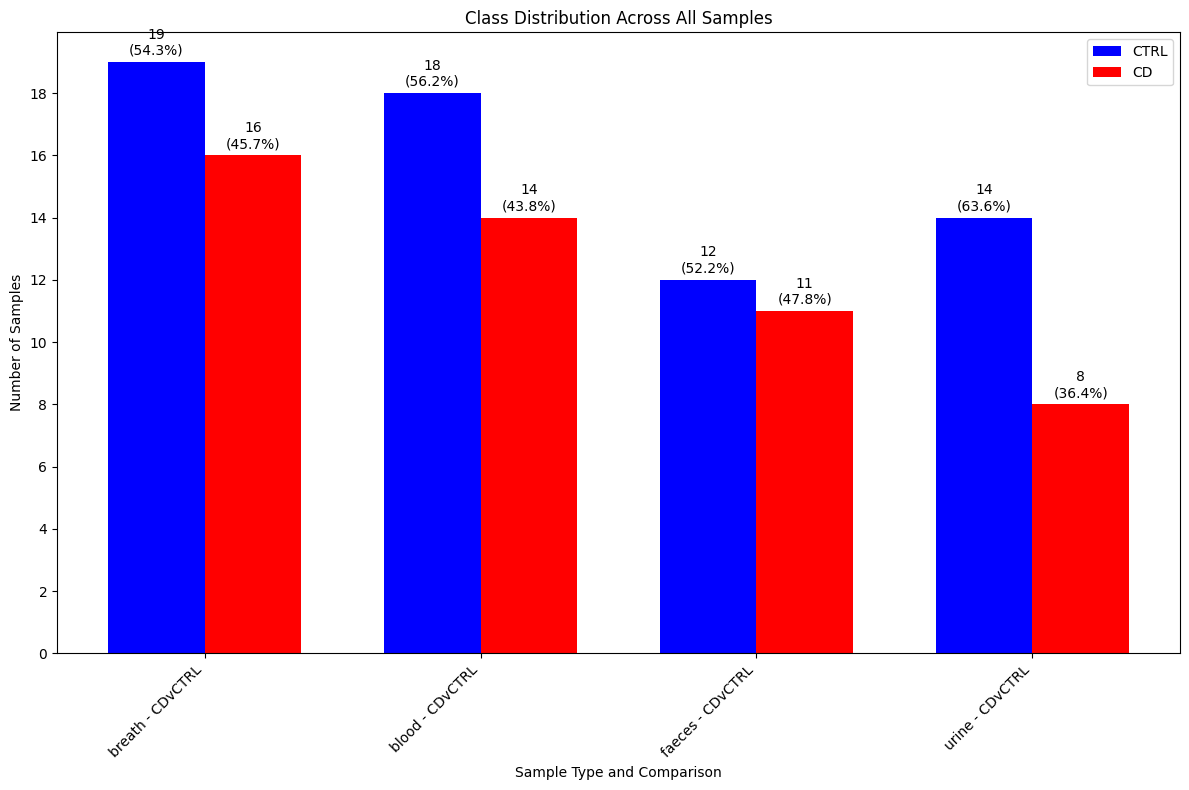

In [4]:
figures_dir = 'G:/My Drive/QMUL/Data_science_and_AI/Assignment/Figures'
os.makedirs(figures_dir, exist_ok=True)

# Function to calculate class counts
def calculate_class_counts(df_dict):
    class_counts = {}
    for sample_type, comparisons in df_dict.items():
        class_counts[sample_type] = {}
        for comparison, df in comparisons.items():
            ctrl_count = sum('CTRL' in col for col in df.columns)
            cd_count = sum('CD' in col for col in df.columns)
            class_counts[sample_type][comparison] = (ctrl_count, cd_count)
    return class_counts

# Calculate class counts
class_counts = calculate_class_counts(df_dict)

# Initialize lists to store data for the plot
sample_types = []
comparisons = []
ctrl_counts = []
cd_counts = []

# Iterate through the class counts dictionary to collect data
for sample_type, comp_dict in class_counts.items():
    for comparison, counts in comp_dict.items():
        sample_types.append(sample_type)
        comparisons.append(comparison)
        ctrl_counts.append(counts[0])
        cd_counts.append(counts[1])

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Sample Type': sample_types,
    'Comparison': comparisons,
    'CTRL': ctrl_counts,
    'CD': cd_counts
})

# Plot the class distributions
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(plot_df))

bar1 = ax.bar(index, plot_df['CTRL'], bar_width, label='CTRL', color='blue')
bar2 = ax.bar(index + bar_width, plot_df['CD'], bar_width, label='CD', color='red')

# Add labels, title, and legend
ax.set_xlabel('Sample Type and Comparison')
ax.set_ylabel('Number of Samples')
ax.set_title('Class Distribution Across All Samples')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(plot_df['Sample Type'] + ' - ' + plot_df['Comparison'], rotation=45, ha='right')
ax.legend()

# Set y-axis to display integers
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Add counts and percentages on top of the bars
total_counts = plot_df['CTRL'] + plot_df['CD']
for bar, count, total in zip(bar1, plot_df['CTRL'], total_counts):
    height = bar.get_height()
    percentage = (count / total) * 100
    ax.annotate(f'{height}\n({percentage:.1f}%)',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for bar, count, total in zip(bar2, plot_df['CD'], total_counts):
    height = bar.get_height()
    percentage = (count / total) * 100
    ax.annotate(f'{height}\n({percentage:.1f}%)',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'class_distribution_summary.png'))
plt.show()

#### Data Quality 

In [5]:
# Function to perform data quality checks
def data_quality_checks(parsed_data):
    for sample_type, comparisons in parsed_data.items():
        print(f"Sample Type: {sample_type}")
        for comparison, df in comparisons.items():
            print(f"  Comparison: {comparison}")
            
            # Check for missing values
            missing_values = df.isnull().sum().sum()
            print(f"    Total Missing Values: {missing_values}")
            
            # Check for outliers using Z-score
            z_scores = np.abs(stats.zscore(df, nan_policy='omit'))
            outliers = (z_scores > 3).sum().sum()
            print(f"    Total Outliers (Z-score > 3): {outliers}")
            print("-" * 40)

# Perform data quality checks for all datasets
data_quality_checks(df_dict)

Sample Type: breath
  Comparison: CDvCTRL
    Total Missing Values: 0
    Total Outliers (Z-score > 3): 1632
----------------------------------------
Sample Type: blood
  Comparison: CDvCTRL
    Total Missing Values: 0
    Total Outliers (Z-score > 3): 1386
----------------------------------------
Sample Type: faeces
  Comparison: CDvCTRL
    Total Missing Values: 0
    Total Outliers (Z-score > 3): 1450
----------------------------------------
Sample Type: urine
  Comparison: CDvCTRL
    Total Missing Values: 0
    Total Outliers (Z-score > 3): 1055
----------------------------------------


#### PCA and silhouette scores

In [6]:
# Function to perform PCA and plot the results
def plot_pca(df_dict, figures_dir):
    silhouette_scores_pca = {}
    for sample_type, comparisons in df_dict.items():
        silhouette_scores_pca[sample_type] = {}
        for comparison, df in comparisons.items():
            # Standardize the data
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(df.T)
            
            # Perform PCA
            pca = PCA(n_components=2)
            pca_result = pca.fit_transform(scaled_data)
            explained_variance = pca.explained_variance_ratio_
            
            # Create a DataFrame with PCA results
            pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
            pca_df['Sample'] = df.columns
            pca_df['Class'] = ['CD' if 'CD' in sample else 'CTRL' for sample in df.columns]
            
            # Compute the silhouette score using PCA data
            labels = np.array(['CD' if 'CD' in sample else 'CTRL' for sample in df.columns])
            labels = np.where(labels == 'CD', 1, 0)
            score_pca = silhouette_score(pca_result, labels)
            silhouette_scores_pca[sample_type][comparison] = score_pca
            print(f'Silhouette Score for {sample_type} - {comparison} using PCA data: {score_pca}')
            
            # Plot the PCA results in 2D
            plt.figure(figsize=(10, 7))
            sns.scatterplot(x='PC1', y='PC2', hue='Class', data=pca_df, palette=['blue', 'red'])
            plt.title(f'PCA 2D Plot for {sample_type} - {comparison}\nSilhouette Score: {score_pca:.2f}')
            plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}% variance)')
            plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}% variance)')
            plt.grid(True)
            plt.savefig(os.path.join(figures_dir, f'{sample_type}_{comparison}_PCA_2D.png'))
            plt.close()
    
    return silhouette_scores_pca

# Compute silhouette scores and plot PCA results for all datasets
silhouette_scores_pca = plot_pca(df_dict, figures_dir)


Silhouette Score for breath - CDvCTRL using PCA data: 0.0342691590438153
Silhouette Score for blood - CDvCTRL using PCA data: -0.038330824726774446
Silhouette Score for faeces - CDvCTRL using PCA data: 0.2682282650609583
Silhouette Score for urine - CDvCTRL using PCA data: -0.013881138472469651


## Machine Learning

#### SVM and Random forest

In [6]:
# Function to run SVM on all sample types
def run_svm(df_dict):
    svm_results = {}
    for sample_type, comparisons in df_dict.items():
        svm_results[sample_type] = {}
        for comparison, df in comparisons.items():
            # Prepare the data
            X = df.T
            y = np.array(['CD' if 'CD' in sample else 'CTRL' for sample in df.columns])
            y = np.where(y == 'CD', 1, 0)
            
            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            
            # Standardize the data
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Train the SVM model
            svm_model = SVC(kernel='linear', random_state=42)
            svm_model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = svm_model.predict(X_test)
            
            # Evaluate the model
            accuracy = accuracy_score(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred)
            svm_results[sample_type][comparison] = {
                'accuracy': accuracy,
                'confusion_matrix': cm
            }
            
            # Print the results
            print(f'SVM Results for {sample_type} - {comparison}:')
            print(f'Accuracy: {accuracy}')
            print('Confusion Matrix:')
            print(cm)
            print('-' * 40)
    
    return svm_results

# Run SVM on all sample types
svm_results = run_svm(df_dict)


SVM Results for breath - CDvCTRL:
Accuracy: 0.6363636363636364
Confusion Matrix:
[[5 1]
 [3 2]]
----------------------------------------
SVM Results for blood - CDvCTRL:
Accuracy: 0.5
Confusion Matrix:
[[4 2]
 [3 1]]
----------------------------------------
SVM Results for faeces - CDvCTRL:
Accuracy: 0.8571428571428571
Confusion Matrix:
[[4 0]
 [1 2]]
----------------------------------------
SVM Results for urine - CDvCTRL:
Accuracy: 0.5714285714285714
Confusion Matrix:
[[4 1]
 [2 0]]
----------------------------------------


In [7]:
# Function to run Random Forest on all sample types
def run_random_forest(df_dict):
    rf_results = {}
    for sample_type, comparisons in df_dict.items():
        rf_results[sample_type] = {}
        for comparison, df in comparisons.items():
            # Prepare the data
            X = df.T
            y = np.array(['CD' if 'CD' in sample else 'CTRL' for sample in df.columns])
            y = np.where(y == 'CD', 1, 0)
            
            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            
            # Standardize the data
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Train the Random Forest model
            rf_model = RandomForestClassifier(random_state=42)
            rf_model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = rf_model.predict(X_test)
            
            # Evaluate the model
            accuracy = accuracy_score(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred)
            rf_results[sample_type][comparison] = {
                'accuracy': accuracy,
                'confusion_matrix': cm
            }
            
            # Print the results
            print(f'Random Forest Results for {sample_type} - {comparison}')
            print(f'Accuracy: {accuracy}')
            print('Confusion Matrix:')
            print(cm)
            print('-' * 40)
    
    return rf_results

# Run Random Forest on all sample types
rf_results = run_random_forest(df_dict)


Random Forest Results for breath - CDvCTRL
Accuracy: 0.6363636363636364
Confusion Matrix:
[[4 2]
 [2 3]]
----------------------------------------
Random Forest Results for blood - CDvCTRL
Accuracy: 0.4
Confusion Matrix:
[[3 3]
 [3 1]]
----------------------------------------
Random Forest Results for faeces - CDvCTRL
Accuracy: 1.0
Confusion Matrix:
[[4 0]
 [0 3]]
----------------------------------------
Random Forest Results for urine - CDvCTRL
Accuracy: 0.8571428571428571
Confusion Matrix:
[[4 1]
 [0 2]]
----------------------------------------


#### Training and Evaluating SVM and Random forest Model for Crohn's Disease Diagnosis

In [8]:
# Function to evaluate the model performance
def evaluate_model_performance(df_dict):
    evaluation_results = {}
    for sample_type, comparisons in df_dict.items():
        evaluation_results[sample_type] = {}
        for comparison, df in comparisons.items():
            # Prepare the data
            X = df.T
            y = np.array(['CD' if 'CD' in sample else 'CTRL' for sample in df.columns])
            y = np.where(y == 'CD', 1, 0)
            
            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            
            # Standardize the data
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Train the SVM model
            svm_model = SVC(kernel='linear', probability=True, random_state=42)
            svm_model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = svm_model.predict(X_test)
            y_pred_proba = svm_model.predict_proba(X_test)[:, 1]
            
            # Evaluate the model
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc_roc = roc_auc_score(y_test, y_pred_proba)
            
            # Store the evaluation results
            evaluation_results[sample_type][comparison] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'auc_roc': auc_roc
            }
            
            # Print the results
            print(f'Evaluation Results for {sample_type} - {comparison}')
            print(f'Accuracy: {accuracy}')
            print(f'Precision: {precision}')
            print(f'Recall: {recall}')
            print(f'F1 Score: {f1}')
            print(f'AUC-ROC: {auc_roc}')
            print('-' * 40)
    
    return evaluation_results

# Evaluate model performance for all datasets
evaluation_results = evaluate_model_performance(df_dict)


Evaluation Results for breath - CDvCTRL
Accuracy: 0.6363636363636364
Precision: 0.6666666666666666
Recall: 0.4
F1 Score: 0.5
AUC-ROC: 0.7333333333333334
----------------------------------------
Evaluation Results for blood - CDvCTRL
Accuracy: 0.5
Precision: 0.3333333333333333
Recall: 0.25
F1 Score: 0.2857142857142857
AUC-ROC: 0.5416666666666666
----------------------------------------
Evaluation Results for faeces - CDvCTRL
Accuracy: 0.8571428571428571
Precision: 1.0
Recall: 0.6666666666666666
F1 Score: 0.8
AUC-ROC: 0.8333333333333333
----------------------------------------
Evaluation Results for urine - CDvCTRL
Accuracy: 0.5714285714285714
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
AUC-ROC: 0.4
----------------------------------------


In [9]:
# Function to evaluate the Random Forest model performance
def evaluate_rf_performance(df_dict):
    rf_evaluation_results = {}
    for sample_type, comparisons in df_dict.items():
        rf_evaluation_results[sample_type] = {}
        for comparison, df in comparisons.items():
            # Prepare the data
            X = df.T
            y = np.array(['CD' if 'CD' in sample else 'CTRL' for sample in df.columns])
            y = np.where(y == 'CD', 1, 0)
            
            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            
            # Standardize the data
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Train the Random Forest model
            rf_model = RandomForestClassifier(random_state=42)
            rf_model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = rf_model.predict(X_test)
            y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
            
            # Evaluate the model
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc_roc = roc_auc_score(y_test, y_pred_proba)
            
            # Store the evaluation results
            rf_evaluation_results[sample_type][comparison] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'auc_roc': auc_roc
            }
            
            # Print the results
            print(f'Random Forest Evaluation Results for {sample_type} - {comparison}:')
            print(f'Accuracy: {accuracy}')
            print(f'Precision: {precision}')
            print(f'Recall: {recall}')
            print(f'F1 Score: {f1}')
            print(f'AUC-ROC: {auc_roc}')
            print('-' * 40)
    
    return rf_evaluation_results

# Evaluate Random Forest model performance for all datasets
rf_evaluation_results = evaluate_rf_performance(df_dict)


Random Forest Evaluation Results for breath - CDvCTRL:
Accuracy: 0.6363636363636364
Precision: 0.6
Recall: 0.6
F1 Score: 0.6
AUC-ROC: 0.7333333333333334
----------------------------------------
Random Forest Evaluation Results for blood - CDvCTRL:
Accuracy: 0.4
Precision: 0.25
Recall: 0.25
F1 Score: 0.25
AUC-ROC: 0.20833333333333334
----------------------------------------
Random Forest Evaluation Results for faeces - CDvCTRL:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC-ROC: 1.0
----------------------------------------
Random Forest Evaluation Results for urine - CDvCTRL:
Accuracy: 0.8571428571428571
Precision: 0.6666666666666666
Recall: 1.0
F1 Score: 0.8
AUC-ROC: 0.9
----------------------------------------


#### Confusion matrices for SVM and Random Forest

In [10]:
# Function to plot confusion matrices
def plot_confusion_matrices(svm_results, figures_dir):
    for sample_type, comparisons in svm_results.items():
        for comparison, results in comparisons.items():
            cm = results['confusion_matrix']
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CTRL', 'CD'])
            disp.plot(cmap=plt.cm.Blues)
            plt.title(f'Confusion Matrix for {sample_type} - {comparison}')
            plt.savefig(os.path.join(figures_dir, f'{sample_type}_{comparison}_confusion_matrix.png'))
            plt.close()

# Plot confusion matrices for all datasets
plot_confusion_matrices(svm_results, figures_dir)

In [11]:
# Function to plot confusion matrices for Random Forest
def plot_rf_confusion_matrices(rf_results, figures_dir):
    for sample_type, comparisons in rf_results.items():
        for comparison, results in comparisons.items():
            cm = results['confusion_matrix']
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CTRL', 'CD'])
            disp.plot(cmap=plt.cm.Blues)
            plt.title(f'Random Forest Confusion Matrix for {sample_type} - {comparison}')
            plt.savefig(os.path.join(figures_dir, f'{sample_type}_{comparison}_rf_confusion_matrix.png'))
            plt.close()

# Plot confusion matrices for Random Forest for all datasets
plot_rf_confusion_matrices(rf_results, figures_dir)

#### Bootstrap validation 

##### Normal (without stratification) KEEP FOR COMPARISON 

In [12]:
# Function to perform bootstrap validation for SVM and Random Forest
def bootstrap_validation(df_dict, n_iterations=500):
    bootstrap_results = {'svm': {}, 'random_forest': {}}
    for sample_type, comparisons in df_dict.items():
        bootstrap_results['svm'][sample_type] = {}
        bootstrap_results['random_forest'][sample_type] = {}
        for comparison, df in comparisons.items():
            X = df.T
            y = np.array(['CD' if 'CD' in sample else 'CTRL' for sample in df.columns])
            y = np.where(y == 'CD', 1, 0)
            
            svm_accuracies = []
            rf_accuracies = []
            for i in range(n_iterations):
                # Resample the data with replacement
                X_resampled, y_resampled = resample(X, y, random_state=i)
                
                # Split the resampled data into training and testing sets
                X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
                
                # Standardize the data
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
                
                # Train the SVM model
                svm_model = SVC(kernel='linear', random_state=42)
                svm_model.fit(X_train, y_train)
                
                # Make predictions with SVM
                y_pred_svm = svm_model.predict(X_test)
                
                # Evaluate the SVM model
                svm_accuracy = accuracy_score(y_test, y_pred_svm)
                svm_accuracies.append(svm_accuracy)
                
                # Train the Random Forest model
                rf_model = RandomForestClassifier(random_state=42)
                rf_model.fit(X_train, y_train)
                
                # Make predictions with Random Forest
                y_pred_rf = rf_model.predict(X_test)
                
                # Evaluate the Random Forest model
                rf_accuracy = accuracy_score(y_test, y_pred_rf)
                rf_accuracies.append(rf_accuracy)
            
            # Store the bootstrap results
            bootstrap_results['svm'][sample_type][comparison] = svm_accuracies
            bootstrap_results['random_forest'][sample_type][comparison] = rf_accuracies
            
            print(f'Bootstrap Validation for {sample_type} - {comparison} (SVM):')
            print(f'Mean Accuracy: {np.mean(svm_accuracies)}')
            print(f'Standard Deviation: {np.std(svm_accuracies)}')
            print('-' * 40)
            
            print(f'Bootstrap Validation for {sample_type} - {comparison} (Random Forest):')
            print(f'Mean Accuracy: {np.mean(rf_accuracies)}')
            print(f'Standard Deviation: {np.std(rf_accuracies)}')
            print('-' * 40)
    
    return bootstrap_results

# Run bootstrap validation for SVM and Random Forest
bootstrap_results = bootstrap_validation(df_dict)

Bootstrap Validation for breath - CDvCTRL (SVM):
Mean Accuracy: 0.794
Standard Deviation: 0.13615875517780796
----------------------------------------
Bootstrap Validation for breath - CDvCTRL (Random Forest):
Mean Accuracy: 0.8163636363636364
Standard Deviation: 0.12764879504340437
----------------------------------------
Bootstrap Validation for blood - CDvCTRL (SVM):
Mean Accuracy: 0.7480000000000001
Standard Deviation: 0.15065191668213188
----------------------------------------
Bootstrap Validation for blood - CDvCTRL (Random Forest):
Mean Accuracy: 0.7338
Standard Deviation: 0.14818083546801863
----------------------------------------
Bootstrap Validation for faeces - CDvCTRL (SVM):
Mean Accuracy: 0.8831428571428571
Standard Deviation: 0.13559212547119365
----------------------------------------
Bootstrap Validation for faeces - CDvCTRL (Random Forest):
Mean Accuracy: 0.9097142857142857
Standard Deviation: 0.11680928115207845
----------------------------------------
Bootstrap Val

#### Bootstrap validation with stratified sampling

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Function to perform bootstrap validation for SVM with stratified sampling
def bootstrap_validation_stratified(df_dict, n_iterations=500):
    bootstrap_results = {'svm': {}}
    for sample_type, comparisons in df_dict.items():
        bootstrap_results['svm'][sample_type] = {}
        for comparison, df in comparisons.items():
            X = df.T.values  # Convert DataFrame to NumPy array
            y = np.array(['CD' if 'CD' in sample else 'CTRL' for sample in df.columns])
            y = np.where(y == 'CD', 1, 0)
            
            svm_accuracies = []
            svm_precisions = []
            svm_recalls = []
            svm_f1_scores = []
            svm_auc_rocs = []
            
            sss = StratifiedShuffleSplit(n_splits=n_iterations, test_size=0.3, random_state=42)
            for train_index, test_index in sss.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                
                # Standardize the data
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
                
                # Train the SVM model
                svm_model = SVC(kernel='linear', probability=True, random_state=42)
                svm_model.fit(X_train, y_train)
                
                # Make predictions with SVM
                y_pred_svm = svm_model.predict(X_test)
                y_pred_proba_svm = svm_model.predict_proba(X_test)[:, 1]
                
                # Evaluate the SVM model
                svm_accuracy = accuracy_score(y_test, y_pred_svm)
                svm_accuracies.append(svm_accuracy)
                
                if np.sum(y_pred_svm) > 0:  # Check for the presence of predicted positive samples
                    svm_precision = precision_score(y_test, y_pred_svm)
                    svm_precisions.append(svm_precision)
                else:
                    svm_precisions.append(0)
                
                svm_recall = recall_score(y_test, y_pred_svm)
                svm_recalls.append(svm_recall)
                
                svm_f1_score = f1_score(y_test, y_pred_svm)
                svm_f1_scores.append(svm_f1_score)
                
                svm_auc_roc = roc_auc_score(y_test, y_pred_proba_svm)
                svm_auc_rocs.append(svm_auc_roc)
            
            # Store the bootstrap results
            bootstrap_results['svm'][sample_type][comparison] = {
                'accuracies': svm_accuracies,
                'precisions': svm_precisions,
                'recalls': svm_recalls,
                'f1_scores': svm_f1_scores,
                'auc_rocs': svm_auc_rocs
            }
            
            print(f'Bootstrap Validation for {sample_type} - {comparison} (SVM):')
            print(f'Mean Accuracy: {np.mean(svm_accuracies)}')
            print(f'Standard Deviation: {np.std(svm_accuracies)}')
            print(f'Mean Precision: {np.mean(svm_precisions)}')
            print(f'Mean Recall: {np.mean(svm_recalls)}')
            print(f'Mean F1-score: {np.mean(svm_f1_scores)}')
            print(f'Mean AUC-ROC: {np.mean(svm_auc_rocs)}')
            print('-' * 40)
    
    return bootstrap_results

# Run bootstrap validation for SVM with stratified sampling
bootstrap_results_stratified = bootstrap_validation_stratified(df_dict)

Bootstrap Validation for breath - CDvCTRL (SVM):
Mean Accuracy: 0.581090909090909
Standard Deviation: 0.13746031733913322
Mean Precision: 0.5421182539682539
Mean Recall: 0.628
Mean F1-score: 0.5660686424686424
Mean AUC-ROC: 0.5792666666666666
----------------------------------------
Bootstrap Validation for blood - CDvCTRL (SVM):
Mean Accuracy: 0.49460000000000004
Standard Deviation: 0.1362014684208654
Mean Precision: 0.38375158730158726
Mean Recall: 0.431
Mean F1-score: 0.38953395493395493
Mean AUC-ROC: 0.456875
----------------------------------------
Bootstrap Validation for faeces - CDvCTRL (SVM):
Mean Accuracy: 0.7562857142857142
Standard Deviation: 0.15088609029628264
Mean Precision: 0.731352380952381
Mean Recall: 0.7859999999999999
Mean F1-score: 0.7302968253968254
Mean AUC-ROC: 0.8463333333333333
----------------------------------------
Bootstrap Validation for urine - CDvCTRL (SVM):
Mean Accuracy: 0.5882857142857142
Standard Deviation: 0.12256410234515434
Mean Precision: 0.424

In [14]:
# Function to perform bootstrap validation for Random Forest with stratified sampling
def bootstrap_validation_rf_stratified(df_dict, n_iterations=500):
    bootstrap_results_rf = {}
    for sample_type, comparisons in df_dict.items():
        bootstrap_results_rf[sample_type] = {}
        for comparison, df in comparisons.items():
            X = df.T.values  # Convert DataFrame to NumPy array
            y = np.array(['CD' if 'CD' in sample else 'CTRL' for sample in df.columns])
            y = np.where(y == 'CD', 1, 0)
            
            rf_accuracies = []
            rf_precisions = []
            rf_recalls = []
            rf_f1_scores = []
            rf_auc_rocs = []
            
            sss = StratifiedShuffleSplit(n_splits=n_iterations, test_size=0.3, random_state=42)
            for train_index, test_index in sss.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                
                # Standardize the data
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
                
                # Train the Random Forest model
                rf_model = RandomForestClassifier(random_state=42)
                rf_model.fit(X_train, y_train)
                
                # Make predictions with Random Forest
                y_pred_rf = rf_model.predict(X_test)
                y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
                
                # Evaluate the Random Forest model
                rf_accuracy = accuracy_score(y_test, y_pred_rf)
                rf_accuracies.append(rf_accuracy)
                
                if np.sum(y_pred_rf) > 0:  # Check for the presence of predicted positive samples
                    rf_precision = precision_score(y_test, y_pred_rf)
                    rf_precisions.append(rf_precision)
                else:
                    rf_precisions.append(0)
                
                rf_recall = recall_score(y_test, y_pred_rf)
                rf_recalls.append(rf_recall)
                
                rf_f1_score = f1_score(y_test, y_pred_rf)
                rf_f1_scores.append(rf_f1_score)
                
                rf_auc_roc = roc_auc_score(y_test, y_pred_proba_rf)
                rf_auc_rocs.append(rf_auc_roc)
            
            # Store the bootstrap results
            bootstrap_results_rf[sample_type][comparison] = {
                'accuracies': rf_accuracies,
                'precisions': rf_precisions,
                'recalls': rf_recalls,
                'f1_scores': rf_f1_scores,
                'auc_rocs': rf_auc_rocs
            }
            
            print(f'Bootstrap Validation for {sample_type} - {comparison} (Random Forest):')
            print(f'Mean Accuracy: {np.mean(rf_accuracies)}')
            print(f'Standard Deviation: {np.std(rf_accuracies)}')
            print(f'Mean Precision: {np.mean(rf_precisions)}')
            print(f'Mean Recall: {np.mean(rf_recalls)}')
            print(f'Mean F1-score: {np.mean(rf_f1_scores)}')
            print(f'Mean AUC-ROC: {np.mean(rf_auc_rocs)}')
            print('-' * 40)
    
    return bootstrap_results_rf

# Run bootstrap validation for Random Forest with stratified sampling
bootstrap_results_rf_stratified = bootstrap_validation_rf_stratified(df_dict)

Bootstrap Validation for breath - CDvCTRL (Random Forest):
Mean Accuracy: 0.6574545454545454
Standard Deviation: 0.1166394458602171
Mean Precision: 0.6686785714285713
Mean Recall: 0.5652
Mean F1-score: 0.5857055167055166
Mean AUC-ROC: 0.707
----------------------------------------
Bootstrap Validation for blood - CDvCTRL (Random Forest):
Mean Accuracy: 0.46079999999999993
Standard Deviation: 0.12830962551578115
Mean Precision: 0.34030555555555553
Mean Recall: 0.3945
Mean F1-score: 0.35244014874014873
Mean AUC-ROC: 0.46220833333333333
----------------------------------------
Bootstrap Validation for faeces - CDvCTRL (Random Forest):
Mean Accuracy: 0.8345714285714284
Standard Deviation: 0.12130548383384514
Mean Precision: 0.7927333333333333
Mean Recall: 0.8979999999999999
Mean F1-score: 0.8272142857142857
Mean AUC-ROC: 0.9246666666666667
----------------------------------------
Bootstrap Validation for urine - CDvCTRL (Random Forest):
Mean Accuracy: 0.5968571428571429
Standard Deviation:

#### Bootstrap validation plots

In [15]:
# Function to plot histogram of bootstrap accuracies from stratified samples
def plot_stratified_bootstrap_histogram(bootstrap_results_stratified, bootstrap_results_rf_stratified, figures_dir):
    for sample_type in bootstrap_results_stratified['svm'].keys():
        for comparison in bootstrap_results_stratified['svm'][sample_type].keys():
            svm_accuracies = bootstrap_results_stratified['svm'][sample_type][comparison]['accuracies']
            rf_accuracies = bootstrap_results_rf_stratified[sample_type][comparison]['accuracies']
            
            plt.figure(figsize=(10, 6))
            plt.hist(svm_accuracies, bins=30, edgecolor='k', alpha=0.7, label='SVM')
            plt.hist(rf_accuracies, bins=30, edgecolor='k', alpha=0.7, label='Random Forest')
            plt.title(f'Bootstrap Accuracy Distribution for {sample_type} - {comparison}')
            plt.xlabel('Accuracy')
            plt.ylabel('Frequency')
            plt.legend(loc='upper right')
            plt.grid(True)
            plt.savefig(os.path.join(figures_dir, f'{sample_type}_{comparison}_bootstrap_accuracy_histogram.png'))
            plt.close()

# Plot histogram of bootstrap accuracies from stratified samples
plot_stratified_bootstrap_histogram(bootstrap_results_stratified, bootstrap_results_rf_stratified, figures_dir)

#### ROC

In [16]:
def plot_roc_curve(df_dict, figures_dir):
    for sample_type, comparisons in df_dict.items():
        for comparison, df in comparisons.items():
            # Prepare the data
            X = df.T
            y = np.array(['CD' if 'CD' in sample else 'CTRL' for sample in df.columns])
            y = np.where(y == 'CD', 1, 0)
            
            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            
            # Standardize the data
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Train the SVM model
            svm_model = SVC(kernel='linear', probability=True, random_state=42)
            svm_model.fit(X_train, y_train)
            
            # Get the predicted probabilities for SVM
            y_pred_proba_svm = svm_model.predict_proba(X_test)[:, 1]
            
            # Compute ROC curve and AUC for SVM
            fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)
            roc_auc_svm = auc(fpr_svm, tpr_svm)
            
            # Train the Random Forest model
            rf_model = RandomForestClassifier(random_state=42)
            rf_model.fit(X_train, y_train)
            
            # Get the predicted probabilities for Random Forest
            y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
            
            # Compute ROC curve and AUC for Random Forest
            fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
            roc_auc_rf = auc(fpr_rf, tpr_rf)
            
            # Plot ROC curve
            plt.figure(figsize=(10, 7))
            plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label=f'SVM ROC curve (area = {roc_auc_svm:.2f})')
            plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'RF ROC curve (area = {roc_auc_rf:.2f})')
            plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for {sample_type} - {comparison}')
            plt.legend(loc='lower right')
            plt.grid(True)
            plt.savefig(os.path.join(figures_dir, f'{sample_type}_{comparison}_roc_curve.png'))
            plt.close()

# Plot ROC curve for all datasets
plot_roc_curve(df_dict, figures_dir)